In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
                
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

# viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12.7,10.27)})

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
def getTCGA(disease):
    path = "/srv/nas/mk2/projects/pan-cancer/TCGA_CCLE_GCP/TCGA/TCGA_{}_counts.tsv.gz"
    files = [path.format(d) for d in disease]
    return files


def readGCP(files, biotype='protein_coding', mean=True):
    """
    Paths to count matrices.
    """
    data_dict = {}
    for f in files:
        key = os.path.basename(f).split("_")[1]
        data = pd.read_csv(f, sep='\t', index_col=0)
        # transcript metadata
        meta = pd.DataFrame([row[:-1] for row in data.index.str.split("|")],
                            columns=['ENST', 'ENSG', 'OTTHUMG', 'OTTHUMT', 'GENE-NUM', 'GENE', 'BP', 'BIOTYPE'])
        meta = pd.MultiIndex.from_frame(meta)
        data.index = meta
        # subset transcripts
        data = data.xs(key=biotype, level='BIOTYPE')
        data = data.droplevel(['ENST', 'ENSG', 'OTTHUMG', 'OTTHUMT', 'GENE-NUM', 'BP'])
        # average gene expression of splice variants
        data = data.T
        if mean:
            data = data.groupby(by=data.columns, axis=1).mean()
        data_dict[key] = data
    return data_dict


def uq_norm(df, q=0.75):
    """
    Upper quartile normalization of GEX for samples.
    """
    quantiles = df.quantile(q=q, axis=1)
    norm = df.divide(quantiles, axis=0)
    return norm

In [4]:
base = "/srv/nas/mk2/projects/pan-cancer/TCGA_CCLE_GCP"
disease = ['BRCA', 'LUAD', 'KIRC', 'THCA', 'PRAD', 'SKCM']

tcga_files = getTCGA(disease)
tcga_meta = pd.read_csv(os.path.join(base, "TCGA/TCGA_GDC_ID_MAP.tsv"), sep="\t")
tcga_raw = readGCP(tcga_files, mean=True)

In [5]:
# combine samples
tcga_raw = pd.concat(tcga_raw.values())

## Normalization

In [6]:
# Upper quartile normalization
tcga_raw = uq_norm(tcga_raw)

In [7]:
# log norm
tcga = tcga_raw.transform(np.log1p)

In [8]:
# downsample
#tcga = tcga_raw.sample(n=40000, axis=1)

# Model

### Experimental Setup

In [9]:
from collections import OrderedDict 
hierarchy = OrderedDict({'Disease':['BRCA', 'LUAD', 'KIRC', 'THCA', 'PRAD', 'SKCM'],
                         'Sample Type':['Primary Tumor', 'Solid Tissue Normal', 'Metastatic']})

In [83]:
from dutils import Experiment
# Define experiment
exp = Experiment(meta_data=tcga_meta,
                 hierarchy=hierarchy,
                 index='CGHubAnalysisID',
                 cases='Case ID',
                 min_samples=20)
# Holdout metastatic
exp.holdout(holdout=['SKCM:Metastatic'])
# Train / Test split
exp.train_test_split(cases='Case ID')
# Return data 
train_data, train_labels = exp.get_data(tcga, subset="train", dtype=np.float32)
test_data, test_labels = exp.get_data(tcga, subset="test", dtype=np.float32)

In [84]:
exp.meta_data['meta'].value_counts()
exp.holdout_meta['meta'].value_counts()

BRCA:Primary Tumor          1119
KIRC:Primary Tumor           542
LUAD:Primary Tumor           536
THCA:Primary Tumor           502
PRAD:Primary Tumor           501
BRCA:Solid Tissue Normal     114
SKCM:Primary Tumor           103
KIRC:Solid Tissue Normal      72
LUAD:Solid Tissue Normal      59
THCA:Solid Tissue Normal      58
PRAD:Solid Tissue Normal      52
SKCM:Metastatic                0
Name: meta, dtype: int64

SKCM:Metastatic             367
THCA:Solid Tissue Normal      0
THCA:Primary Tumor            0
SKCM:Primary Tumor            0
PRAD:Solid Tissue Normal      0
PRAD:Primary Tumor            0
LUAD:Solid Tissue Normal      0
LUAD:Primary Tumor            0
KIRC:Solid Tissue Normal      0
KIRC:Primary Tumor            0
BRCA:Solid Tissue Normal      0
BRCA:Primary Tumor            0
Name: meta, dtype: int64

In [85]:
# Inspect class split distributions
target = 'meta'
case_counts = exp.meta_data[target].value_counts()
exp.train_meta[target].value_counts()[case_counts.index.to_numpy()] / case_counts
exp.test_meta[target].value_counts()[case_counts.index.to_numpy()] / case_counts

BRCA:Primary Tumor          0.803396
KIRC:Primary Tumor          0.804428
LUAD:Primary Tumor          0.804104
THCA:Primary Tumor          0.788845
PRAD:Primary Tumor          0.812375
BRCA:Solid Tissue Normal    0.763158
SKCM:Primary Tumor          0.747573
KIRC:Solid Tissue Normal    0.819444
LUAD:Solid Tissue Normal    0.864407
THCA:Solid Tissue Normal    0.827586
PRAD:Solid Tissue Normal    0.769231
SKCM:Metastatic                  NaN
Name: meta, dtype: float64

BRCA:Primary Tumor          0.196604
KIRC:Primary Tumor          0.195572
LUAD:Primary Tumor          0.195896
THCA:Primary Tumor          0.211155
PRAD:Primary Tumor          0.187625
BRCA:Solid Tissue Normal    0.236842
SKCM:Primary Tumor          0.252427
KIRC:Solid Tissue Normal    0.180556
LUAD:Solid Tissue Normal    0.135593
THCA:Solid Tissue Normal    0.172414
PRAD:Solid Tissue Normal    0.230769
SKCM:Metastatic                  NaN
Name: meta, dtype: float64

In [86]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
#torch.manual_seed(123)

from trainer import fit
import visualization as vis
from tcga_datasets import SiameseDataset
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

Cuda is available: True


# Siamese Network

In [87]:
siamese_train_dataset = SiameseDataset(data=train_data,
                                       labels=train_labels,
                                       train=True)
siamese_test_dataset = SiameseDataset(data=test_data,
                                      labels=test_labels,
                                      train=False)

In [88]:
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss, TripletLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
n_samples, n_features = siamese_train_dataset.train_data.shape
embedding_net = EmbeddingNet(n_features, 2)
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
# print training metrics every log_interval * batch_size
log_interval = round(len(siamese_train_dataset)/4/batch_size)

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=19594, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [89]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/2931 (0%)]	Loss: 0.373968
Train: [736/2931 (25%)]	Loss: 0.070880
Train: [1472/2931 (50%)]	Loss: 0.067606
Train: [2208/2931 (75%)]	Loss: 0.039460
Epoch: 1/10. Train set: Average loss: 0.0565
Epoch: 1/10. Validation set: Average loss: 0.0258
Train: [0/2931 (0%)]	Loss: 0.015018
Train: [736/2931 (25%)]	Loss: 0.032816
Train: [1472/2931 (50%)]	Loss: 0.030895
Train: [2208/2931 (75%)]	Loss: 0.025633
Epoch: 2/10. Train set: Average loss: 0.0287
Epoch: 2/10. Validation set: Average loss: 0.0188
Train: [0/2931 (0%)]	Loss: 0.010623
Train: [736/2931 (25%)]	Loss: 0.023359
Train: [1472/2931 (50%)]	Loss: 0.021963
Train: [2208/2931 (75%)]	Loss: 0.019648
Epoch: 3/10. Train set: Average loss: 0.0212
Epoch: 3/10. Validation set: Average loss: 0.0202
Train: [0/2931 (0%)]	Loss: 0.010025
Train: [736/2931 (25%)]	Loss: 0.021100
Train: [1472/2931 (50%)]	Loss: 0.018600
Train: [2208/2931 (75%)]	Loss: 0.017327
Epoch: 4/10. Train set: Average loss: 0.0188
Epoch: 4/10. Validation set: Average loss: 0.0159


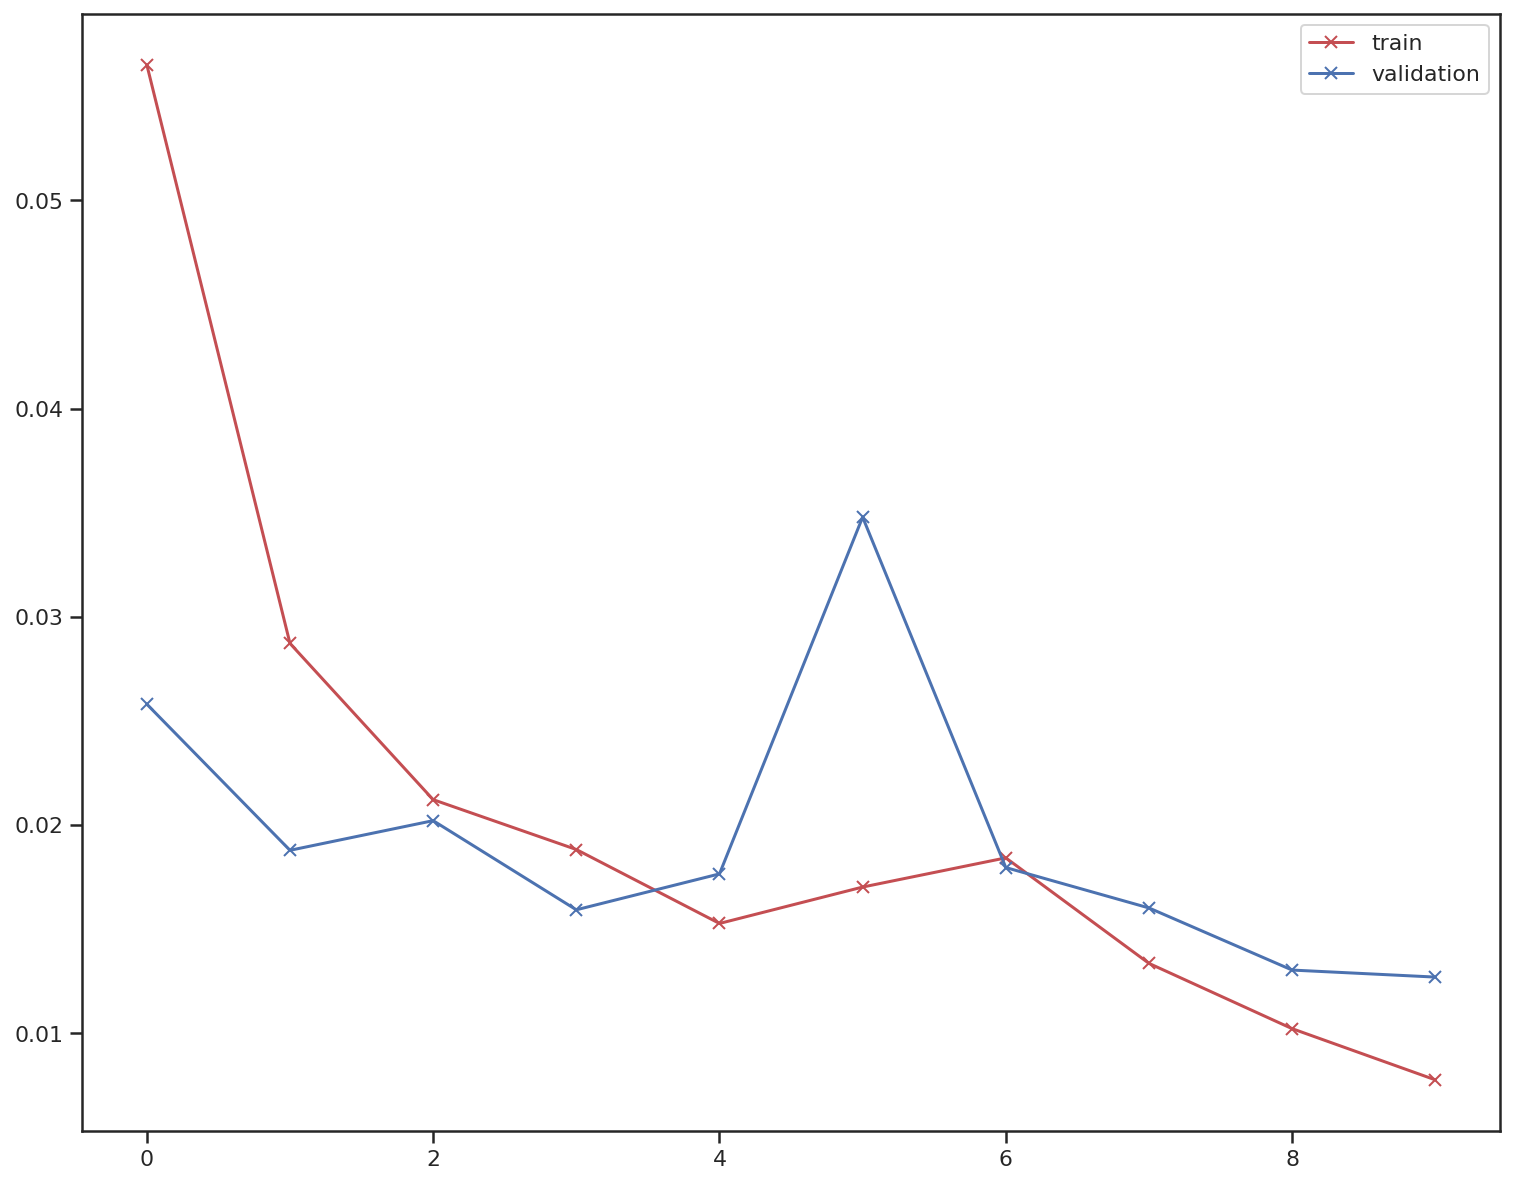

In [90]:
plt.plot(range(0, n_epochs), train_loss, 'rx-', label='train')
plt.plot(range(0, n_epochs), val_loss, 'bx-', label='validation')
plt.legend()

Text(0.5, 1.0, 'PanCancer Train: Siamese')

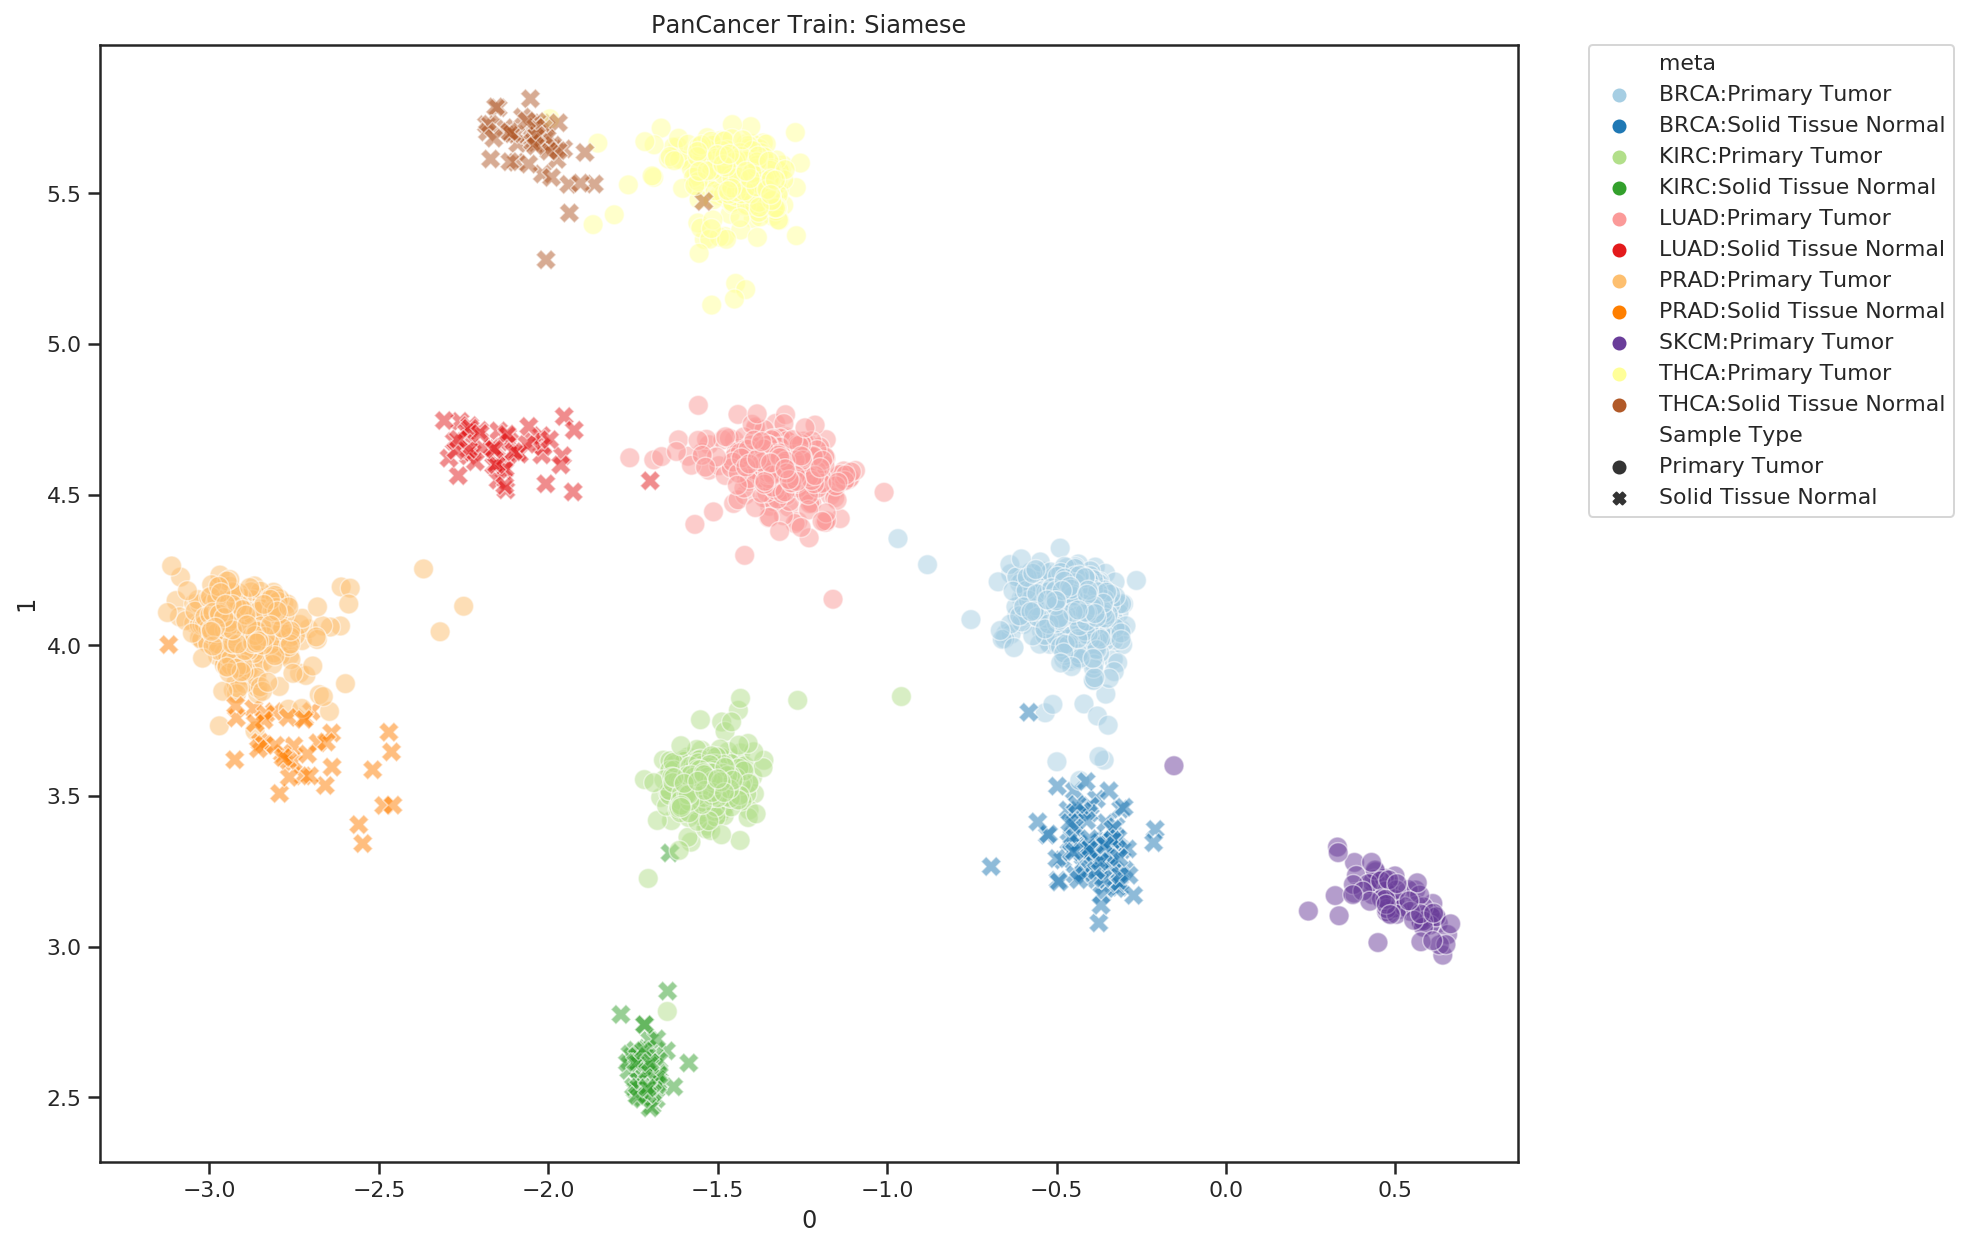

In [91]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(siamese_train_dataset.train_data, siamese_train_dataset.labels, model)
vis.sns_plot_embeddings(train_embeddings_cl, train_labels_cl, exp.labels_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer Train: Siamese')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 1.0, 'PanCancer Test: Siamese')

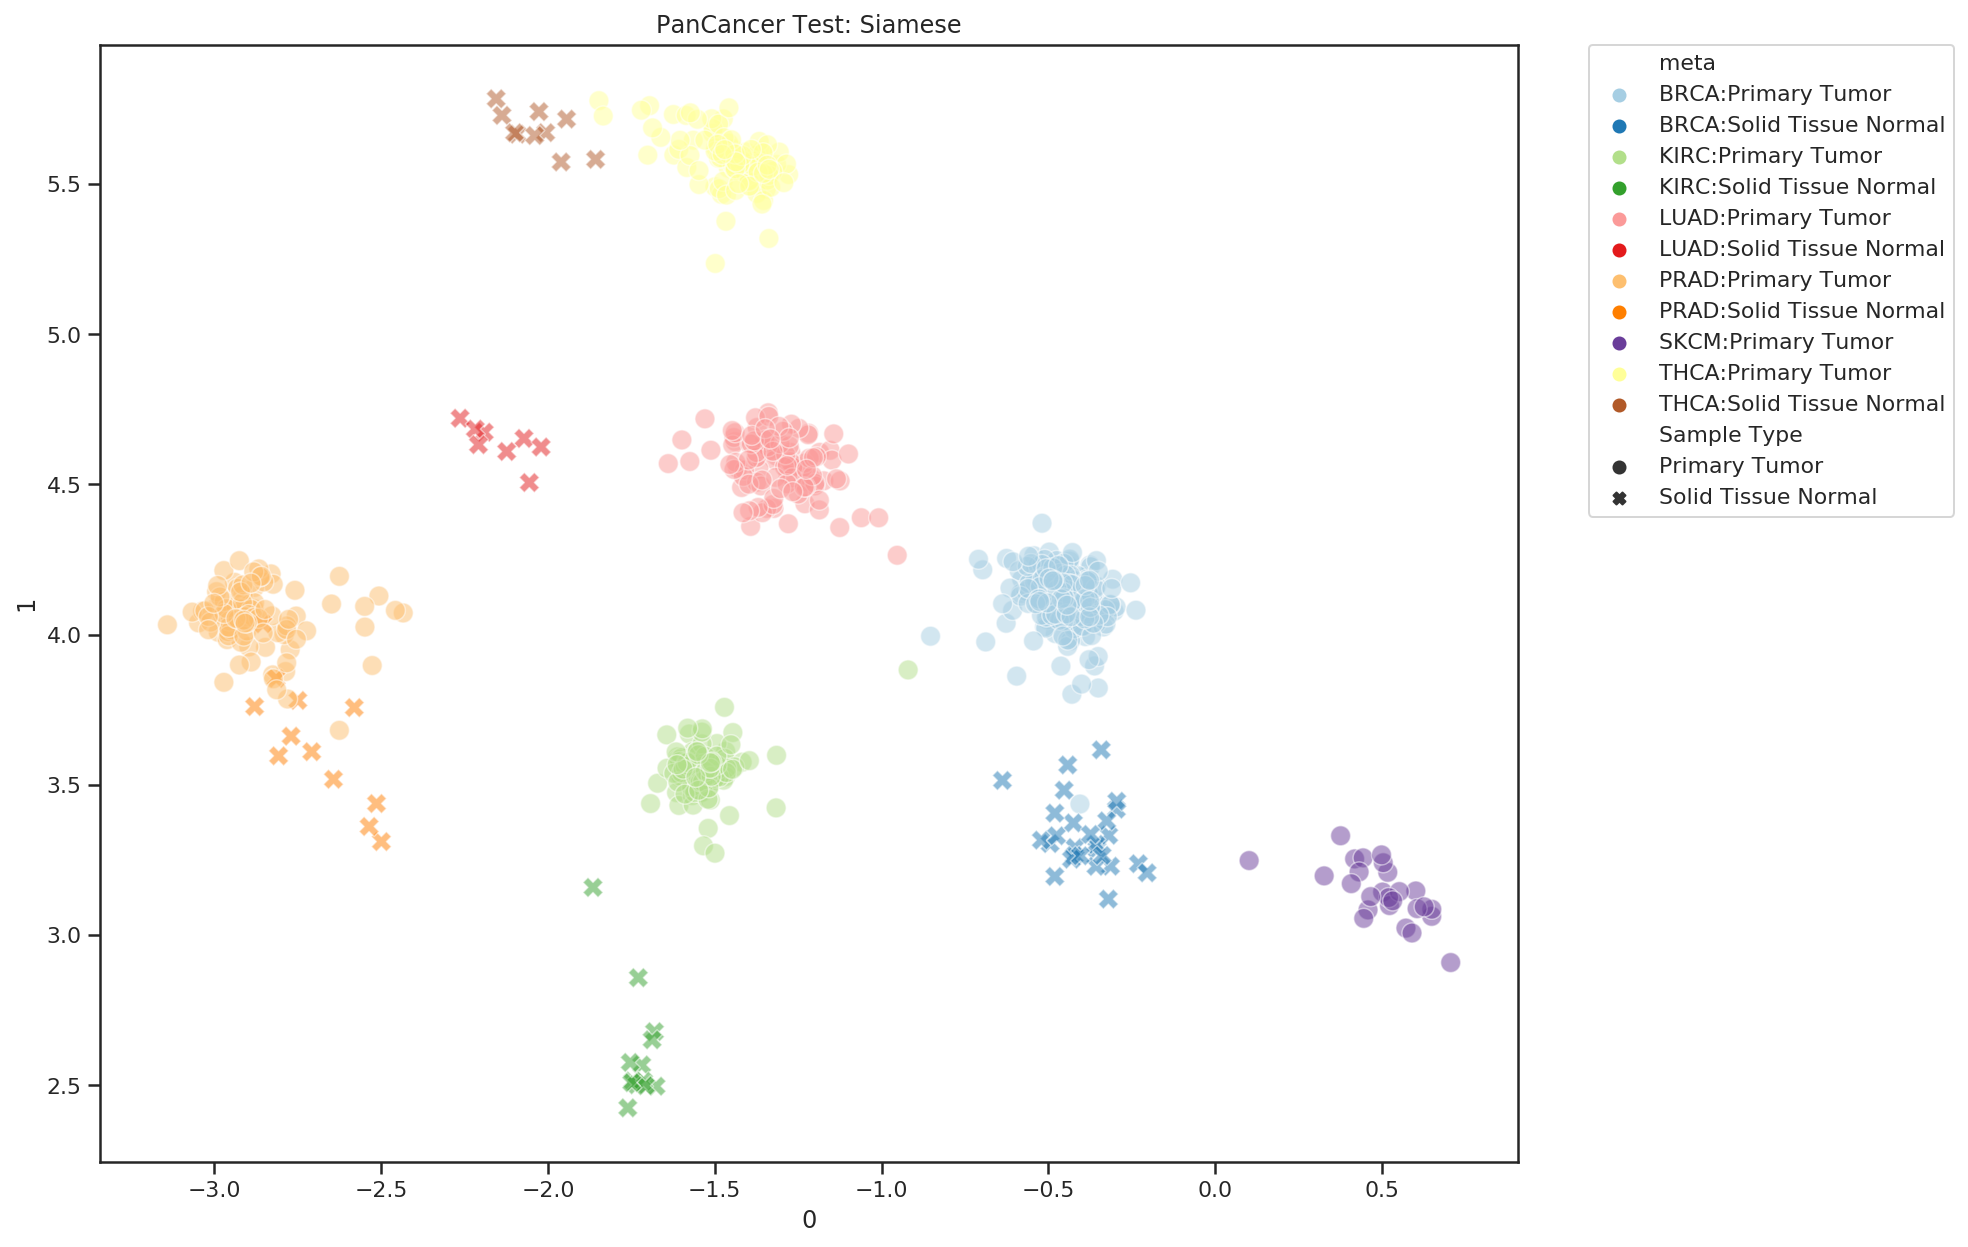

In [92]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(siamese_test_dataset.test_data, siamese_test_dataset.labels, model)
vis.sns_plot_embeddings(val_embeddings_baseline, val_labels_baseline, exp.labels_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer Test: Siamese')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [93]:
holdout_data, holdout_labels = exp.get_data(tcga, subset="holdout", dtype=np.float32)
siamese_holdout_dataset = SiameseDataset(data=holdout_data,
                                         labels=holdout_labels,
                                         train=True)

Text(0.5, 1.0, 'PanCancer Holdout: SKCM:Metastatic')

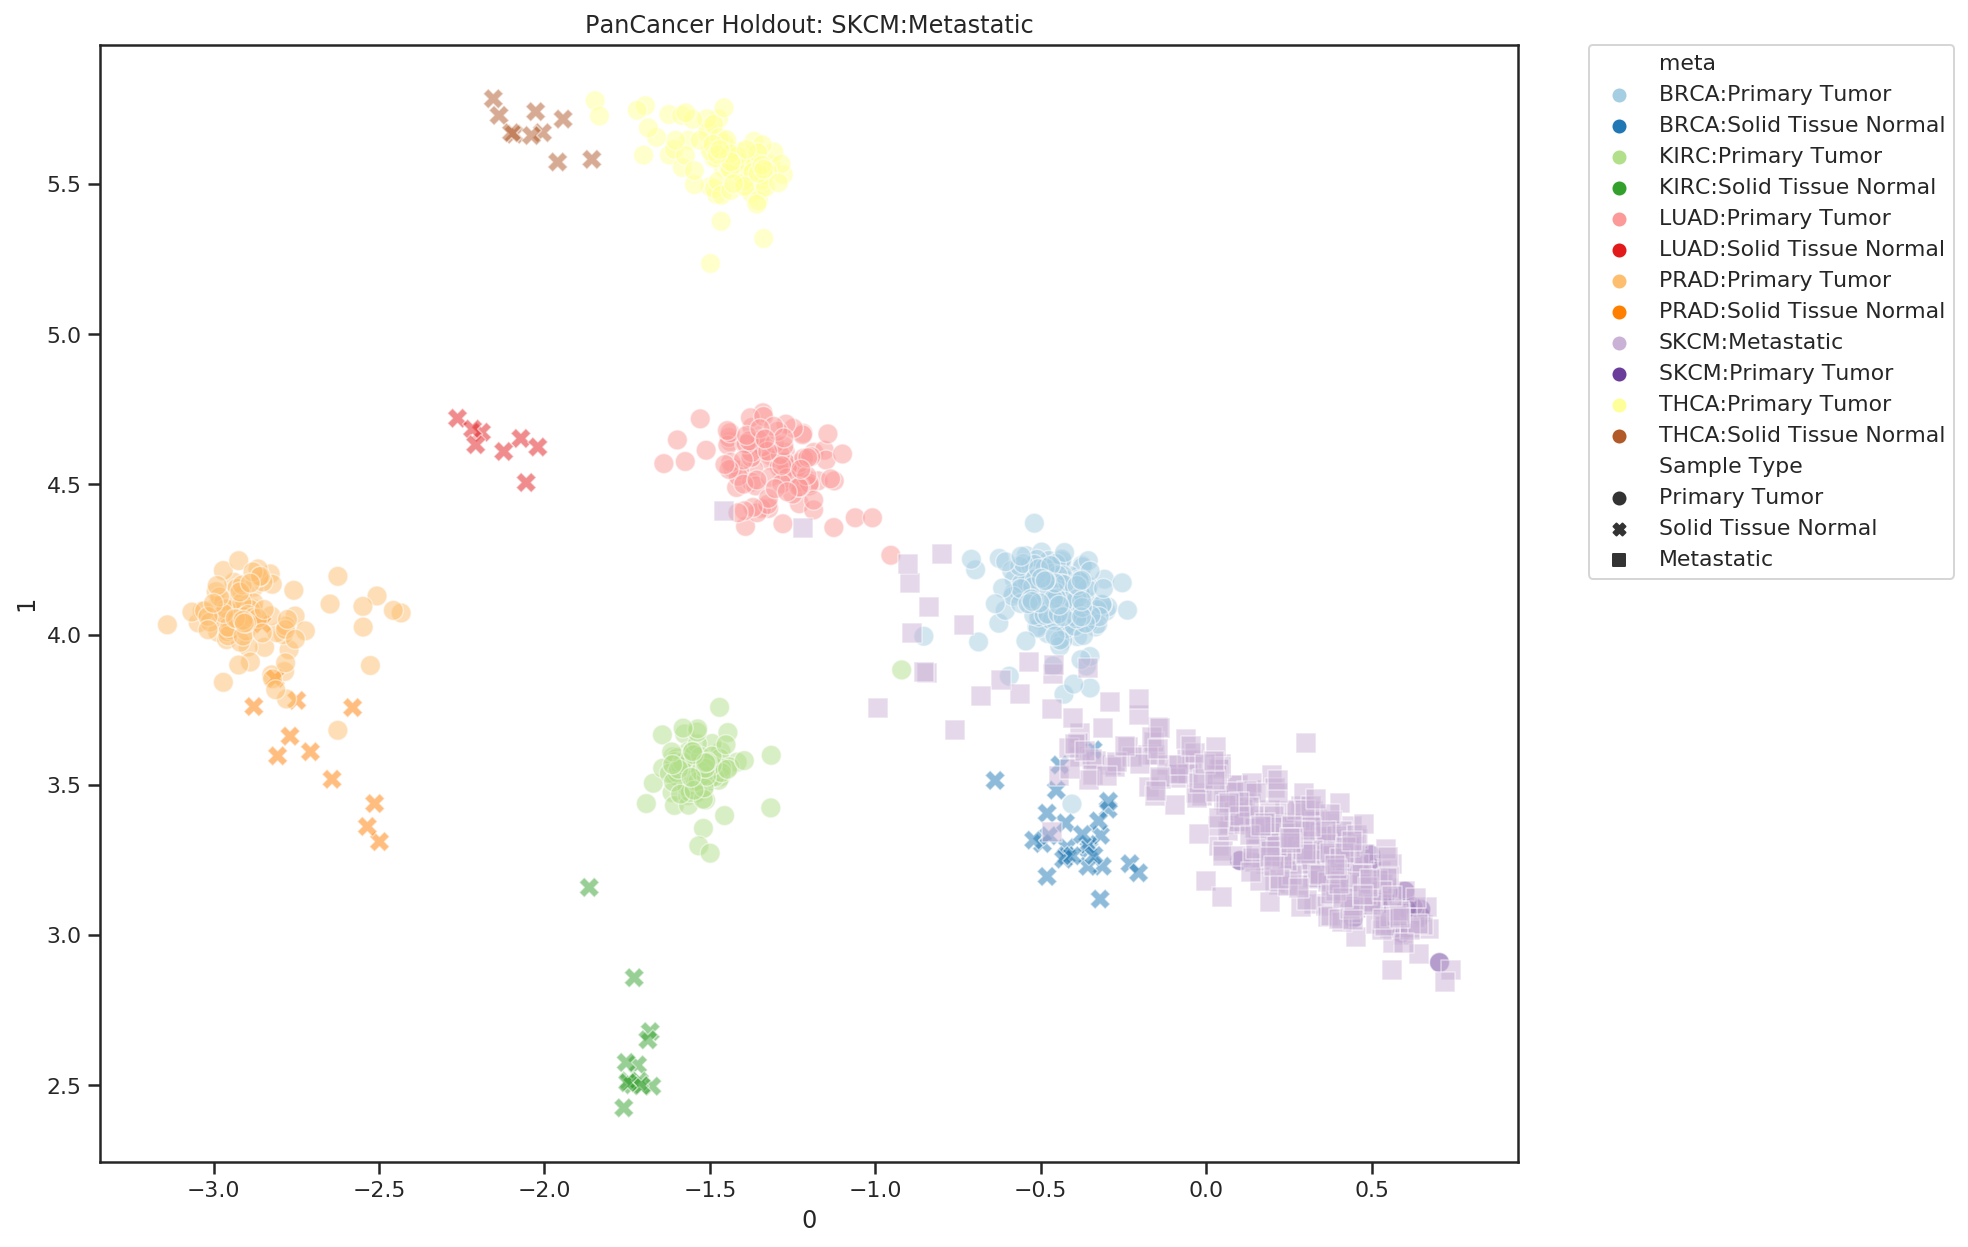

In [95]:
holdout_embeddings_baseline, holdout_labels_baseline = vis.extract_embeddings(siamese_holdout_dataset.train_data, siamese_holdout_dataset.labels, model)
# combine with validation for plotting
comb_embeddings_baseline = np.concatenate((val_embeddings_baseline, holdout_embeddings_baseline))
comb_labels_baseline = np.concatenate((val_labels_baseline, holdout_labels_baseline))
vis.sns_plot_embeddings(comb_embeddings_baseline, comb_labels_baseline, exp.labels_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer Holdout: SKCM:Metastatic')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)